In [21]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/bumpcosmologygwtc3_m1m2`


h_plot (generic function with 1 method)

# Load Events

In [2]:
## Samples and Selection

## Set up paths
struct Paths
    gwtc_2_dir::String
    gwtc_3_dir::String
    evt_table_file::String
    o1o2o3_sensitivity_file::String
end

system = :rusty
if system == :rusty
    paths = Paths(
        "/mnt/home/ccalvk/ceph/GWTC-2.1", 
        "/mnt/home/ccalvk/ceph/GWTC-3", 
        "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
        "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5"
    )
elseif system == :wmflaptop
    paths = Paths(
        "/Users/wfarr/Research/gwtc-2.1",
        "/Users/wfarr/Research/o3b_data/PE",
        "/Users/wfarr/Research/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
        "/Users/wfarr/Research/o3b_data/O1O2O3-Sensitivity/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5"
    )
end

Paths("/mnt/home/ccalvk/ceph/GWTC-2.1", "/mnt/home/ccalvk/ceph/GWTC-3", "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json", "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5")

In [3]:
## Load PE
all_pe = load_pe(; gwtc_2_dir=paths.gwtc_2_dir, gwtc_3_dir=paths.gwtc_3_dir)
evt_table = load_event_table(paths.evt_table_file)
all_pe = join_pe_evt_tables(all_pe, evt_table)
all_pe[:, :prior_logwt_m1qzchie] = li_nocosmo_prior_logwt_m1qzchie(all_pe)
pe_table = far_cut(chirp_mass_cut(all_pe))

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ BumpCosmologyGWTC3 /mnt/home/sroy1/bumpcosmologygwtc3_m1m2/src/load.jl:26


Row,spin_2y,dec,chirp_mass,redshift,theta_jn,ra,a_1,chi_p_2spin,viewing_angle,mass_1_source,cos_tilt_2,spin_2x,mass_2,cos_iota,chi_eff,mass_2_source,psi_J,log_likelihood,symmetric_mass_ratio,phi_12,spin_2z,phase,a_2,beta,spin_1z,chirp_mass_source,mass_ratio,comoving_distance,total_mass,mass_1,total_mass_source,chi_p,tilt_1,phi_1,tilt_2,cos_tilt_1,iota,luminosity_distance,phi_2,cos_theta_jn,inverted_mass_ratio,spin_1y,phi_jl,psi,spin_1x,gwname,commonName,far,prior_logwt_m1qzchie
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,SubStrin…,SubStrin…,Float64,Float64
1,0.0157482,-1.2029,30.9684,0.0968552,2.77079,1.28323,0.00150978,0.0142601,0.370807,37.7342,0.827167,0.000942395,30.7108,-0.931191,0.00928814,27.999,2.70339,320.05,0.244516,2.46959,0.0232219,3.78693,0.028074,0.00264939,-0.0010508,28.2338,0.742006,418.022,72.0998,41.3889,65.7332,0.0112211,2.3406,5.32462,0.596749,-0.695997,2.76846,458.427,1.51103,-0.932035,1.3477,-0.000887186,2.07373,1.12909,0.000623018,GW150914_095045,GW150914,1.0e-7,4.54338
2,0.306186,-1.17447,31.6976,0.0858721,2.58701,1.12687,0.927965,0.804829,0.554584,36.8689,-0.708659,-0.277814,33.1735,-0.876785,0.0308062,30.5501,3.19656,324.407,0.247804,0.924199,-0.415259,1.61676,0.585979,0.294629,0.400422,29.1909,0.828614,371.601,73.2084,40.0349,67.419,0.837126,1.12463,1.38345,2.35839,0.431506,2.63993,403.445,2.30765,-0.850119,1.20683,0.822478,5.85641,2.20776,0.155915,GW150914_095045,GW150914,1.0e-7,4.17533
3,-0.281979,-1.20404,29.1559,0.0984072,2.65664,2.28386,0.377052,0.480531,0.48495,33.7307,0.069959,0.336426,30.3349,-0.864843,-0.164482,27.6172,1.85062,324.894,0.247517,5.15309,0.0307853,3.82701,0.440048,0.136484,-0.324358,26.5438,0.818754,424.561,67.3849,37.05,61.3479,0.349319,2.60655,0.43251,1.50078,-0.860247,2.61563,466.256,5.5856,-0.884698,1.22137,0.0805821,0.184376,0.549502,0.174548,GW150914_095045,GW150914,1.0e-7,4.0161
4,-0.0257892,-1.28148,29.4337,0.0788087,2.46328,1.66579,0.436312,0.678088,0.678313,31.681,-0.548917,-0.578377,33.4479,-0.670639,-0.148147,31.0044,2.87312,325.099,0.249971,0.599913,-0.380195,0.994084,0.692628,0.250073,0.0789466,27.2835,0.978645,341.613,67.6256,34.1777,62.6854,0.564844,1.38885,2.58624,2.15186,0.180941,2.30587,368.478,3.18615,-0.778632,1.02182,0.226246,0.569816,1.58707,-0.364621,GW150914_095045,GW150914,1.0e-7,3.47967
5,-0.615255,-1.22545,28.3426,0.093687,2.78603,2.18355,0.53497,0.32345,0.355559,35.457,-0.27069,-0.298152,27.4948,-0.906833,-0.213818,25.1395,4.77553,322.9,0.242752,2.08325,-0.192245,2.68165,0.710205,0.16795,-0.229113,25.9147,0.709015,404.658,66.2736,38.7788,60.5965,0.483425,2.01338,2.17789,1.84491,-0.428273,2.7065,442.491,4.26114,-0.937452,1.41041,0.397043,2.83741,2.81668,-0.275784,GW150914_095045,GW150914,1.0e-7,3.76129
6,0.0101604,-1.2815,30.2896,0.105684,2.71688,1.89592,0.482283,0.45148,0.424714,33.7674,0.803428,-0.00136464,32.456,-0.945471,-0.0667451,29.3538,2.48545,323.721,0.248778,3.39295,0.0138334,4.20109,0.017218,0.134265,-0.136791,27.3944,0.869293,455.154,69.7921,37.3361,63.1212,0.462477,1.85838,4.59454,0.637765,-0.283633,2.80984,503.16,1.70431,-0.911157,1.15036,-0.459269,5.40313,1.17959,-0.0543767,GW150914_095045,GW150914,1.0e-7,4.49273
7,-0.0143139,-1.22618,30.8565,0.120825,2.83255,2.33255,0.118997,0.0917852,0.309042,34.8008,0.970927,0.000399219,32.2669,-0.948892,-0.0101696,28.7885,3.17053,319.882,0.247765,4.02482,0.0580812,5.17008,0.0598203,0.0282465,-0.0666291,27.5301,0.827237,518.446,71.2725,39.0056,63.5893,0.0985938,2.16509,0.715448,0.241722,-0.559925,2.8205,580.964,4.74027,-0.952625,1.20884,0.0646731,2.74057,1.51725,0.0744185,GW150914_095045,GW150914,1.0e-7,5.00503
8,-0.00522301,-1.25144,29.8868,0.118836,3.04766,2.17208,0.171419,0.835042,0.09

In [4]:
## Check number of events
n0p1, n0p5, n0p9 = length(groupby(far_cut(chirp_mass_cut(all_pe, thresh=0.1)), :gwname)), length(groupby(far_cut(chirp_mass_cut(all_pe, thresh=0.5)), :gwname)), length(groupby(far_cut(chirp_mass_cut(all_pe, thresh=0.9)), :gwname))
@info "N(p > 0.1) = $(n0p1); N(p > 0.5) = $(n0p5); N(p > 0.9) = $(n0p9)"

┌ Info: N(p > 0.1) = 55; N(p > 0.5) = 51; N(p > 0.9) = 44
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_m1m2/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:3


In [5]:
# Just plot the 0.5 sample:
pe = far_cut(chirp_mass_cut(all_pe, thresh=0.5))

Row,spin_2y,dec,chirp_mass,redshift,theta_jn,ra,a_1,chi_p_2spin,viewing_angle,mass_1_source,cos_tilt_2,spin_2x,mass_2,cos_iota,chi_eff,mass_2_source,psi_J,log_likelihood,symmetric_mass_ratio,phi_12,spin_2z,phase,a_2,beta,spin_1z,chirp_mass_source,mass_ratio,comoving_distance,total_mass,mass_1,total_mass_source,chi_p,tilt_1,phi_1,tilt_2,cos_tilt_1,iota,luminosity_distance,phi_2,cos_theta_jn,inverted_mass_ratio,spin_1y,phi_jl,psi,spin_1x,gwname,commonName,far,prior_logwt_m1qzchie
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,SubStrin…,SubStrin…,Float64,Float64
1,0.0157482,-1.2029,30.9684,0.0968552,2.77079,1.28323,0.00150978,0.0142601,0.370807,37.7342,0.827167,0.000942395,30.7108,-0.931191,0.00928814,27.999,2.70339,320.05,0.244516,2.46959,0.0232219,3.78693,0.028074,0.00264939,-0.0010508,28.2338,0.742006,418.022,72.0998,41.3889,65.7332,0.0112211,2.3406,5.32462,0.596749,-0.695997,2.76846,458.427,1.51103,-0.932035,1.3477,-0.000887186,2.07373,1.12909,0.000623018,GW150914_095045,GW150914,1.0e-7,4.54338
2,0.306186,-1.17447,31.6976,0.0858721,2.58701,1.12687,0.927965,0.804829,0.554584,36.8689,-0.708659,-0.277814,33.1735,-0.876785,0.0308062,30.5501,3.19656,324.407,0.247804,0.924199,-0.415259,1.61676,0.585979,0.294629,0.400422,29.1909,0.828614,371.601,73.2084,40.0349,67.419,0.837126,1.12463,1.38345,2.35839,0.431506,2.63993,403.445,2.30765,-0.850119,1.20683,0.822478,5.85641,2.20776,0.155915,GW150914_095045,GW150914,1.0e-7,4.17533
3,-0.281979,-1.20404,29.1559,0.0984072,2.65664,2.28386,0.377052,0.480531,0.48495,33.7307,0.069959,0.336426,30.3349,-0.864843,-0.164482,27.6172,1.85062,324.894,0.247517,5.15309,0.0307853,3.82701,0.440048,0.136484,-0.324358,26.5438,0.818754,424.561,67.3849,37.05,61.3479,0.349319,2.60655,0.43251,1.50078,-0.860247,2.61563,466.256,5.5856,-0.884698,1.22137,0.0805821,0.184376,0.549502,0.174548,GW150914_095045,GW150914,1.0e-7,4.0161
4,-0.0257892,-1.28148,29.4337,0.0788087,2.46328,1.66579,0.436312,0.678088,0.678313,31.681,-0.548917,-0.578377,33.4479,-0.670639,-0.148147,31.0044,2.87312,325.099,0.249971,0.599913,-0.380195,0.994084,0.692628,0.250073,0.0789466,27.2835,0.978645,341.613,67.6256,34.1777,62.6854,0.564844,1.38885,2.58624,2.15186,0.180941,2.30587,368.478,3.18615,-0.778632,1.02182,0.226246,0.569816,1.58707,-0.364621,GW150914_095045,GW150914,1.0e-7,3.47967
5,-0.615255,-1.22545,28.3426,0.093687,2.78603,2.18355,0.53497,0.32345,0.355559,35.457,-0.27069,-0.298152,27.4948,-0.906833,-0.213818,25.1395,4.77553,322.9,0.242752,2.08325,-0.192245,2.68165,0.710205,0.16795,-0.229113,25.9147,0.709015,404.658,66.2736,38.7788,60.5965,0.483425,2.01338,2.17789,1.84491,-0.428273,2.7065,442.491,4.26114,-0.937452,1.41041,0.397043,2.83741,2.81668,-0.275784,GW150914_095045,GW150914,1.0e-7,3.76129
6,0.0101604,-1.2815,30.2896,0.105684,2.71688,1.89592,0.482283,0.45148,0.424714,33.7674,0.803428,-0.00136464,32.456,-0.945471,-0.0667451,29.3538,2.48545,323.721,0.248778,3.39295,0.0138334,4.20109,0.017218,0.134265,-0.136791,27.3944,0.869293,455.154,69.7921,37.3361,63.1212,0.462477,1.85838,4.59454,0.637765,-0.283633,2.80984,503.16,1.70431,-0.911157,1.15036,-0.459269,5.40313,1.17959,-0.0543767,GW150914_095045,GW150914,1.0e-7,4.49273
7,-0.0143139,-1.22618,30.8565,0.120825,2.83255,2.33255,0.118997,0.0917852,0.309042,34.8008,0.970927,0.000399219,32.2669,-0.948892,-0.0101696,28.7885,3.17053,319.882,0.247765,4.02482,0.0580812,5.17008,0.0598203,0.0282465,-0.0666291,27.5301,0.827237,518.446,71.2725,39.0056,63.5893,0.0985938,2.16509,0.715448,0.241722,-0.559925,2.8205,580.964,4.74027,-0.952625,1.20884,0.0646731,2.74057,1.51725,0.0744185,GW150914_095045,GW150914,1.0e-7,5.00503
8,-0.00522301,-1.25144,29.8868,0.118836,3.04766,2.17208,0.171419,0.835042,0.09

# Load Trace

In [6]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.07, minimum Neff_sel = 1762.1, 4*Nobs = 204
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_m1m2/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sdnNjb2RlLXJlbW90ZQ==.jl:4


In [7]:
trace = trace_samples_0p5

InferenceData with groups:
  > posterior
  > sample_stats

# $q-\chi_\mathrm{eff}$ Plots

## PE Contours

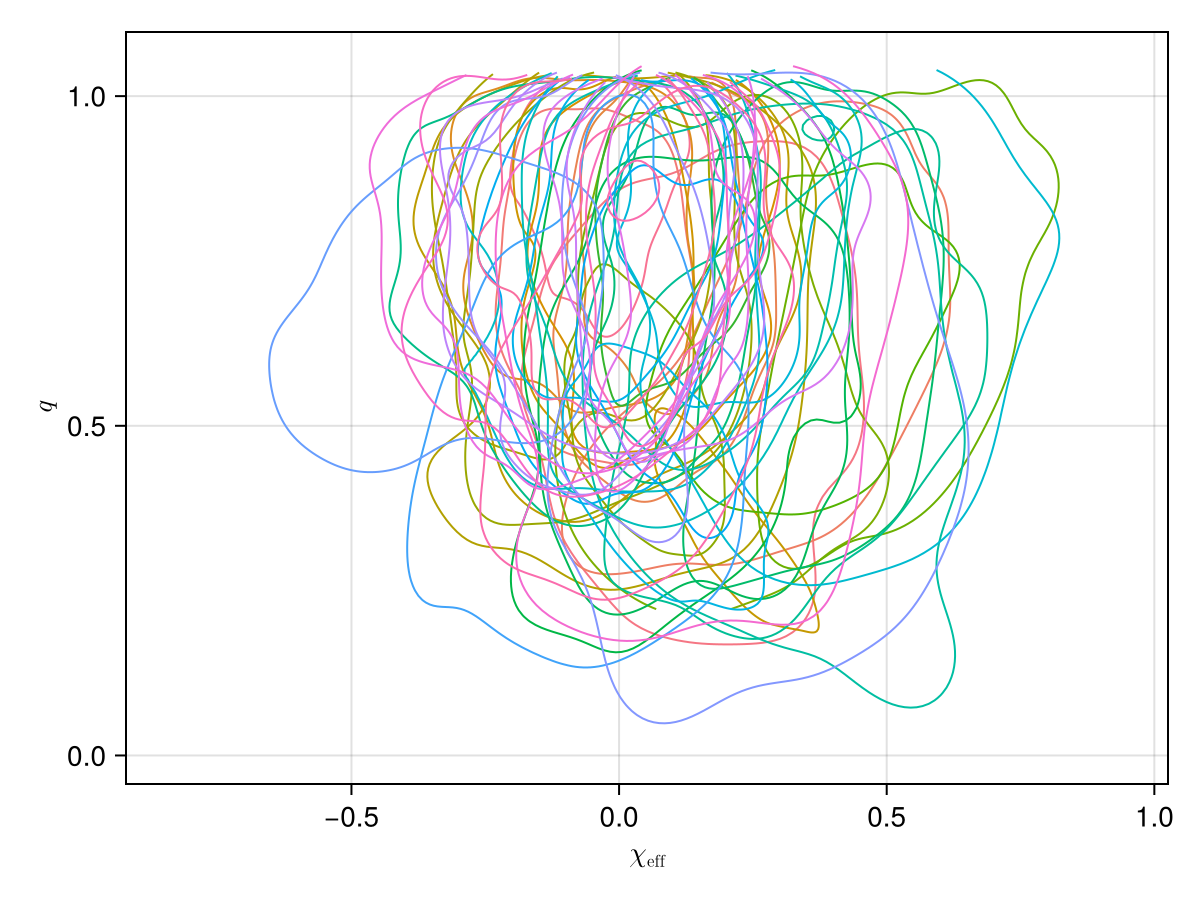

In [11]:
## q-chi_eff contour plot
pe_grouped = groupby(pe, :gwname)
n = length(pe_grouped)

cs = categorical_palette(n)
rng = Random.Xoshiro(0xaf91589a0f32ada4)

f = Figure()
a = Axis(f[1,1], xlabel=L"\chi_\mathrm{eff}", ylabel=L"q")

@progress for (c, evt) in zip(cs, pe_grouped)
    inds = rand(rng, 1:size(evt, 1), 256)
    e = evt[inds, :]
    kdecontour!(a, e.chi_eff, e.mass_ratio, color=c, levels=[0.1])
end
f

## Pop Plots

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


Standard deviation of dNdchi_p10: 5.585183559176871
Standard deviation of dNdchi_median: 9.031393676818745
Standard deviation of dNdchi_p90: 16.034900662273028


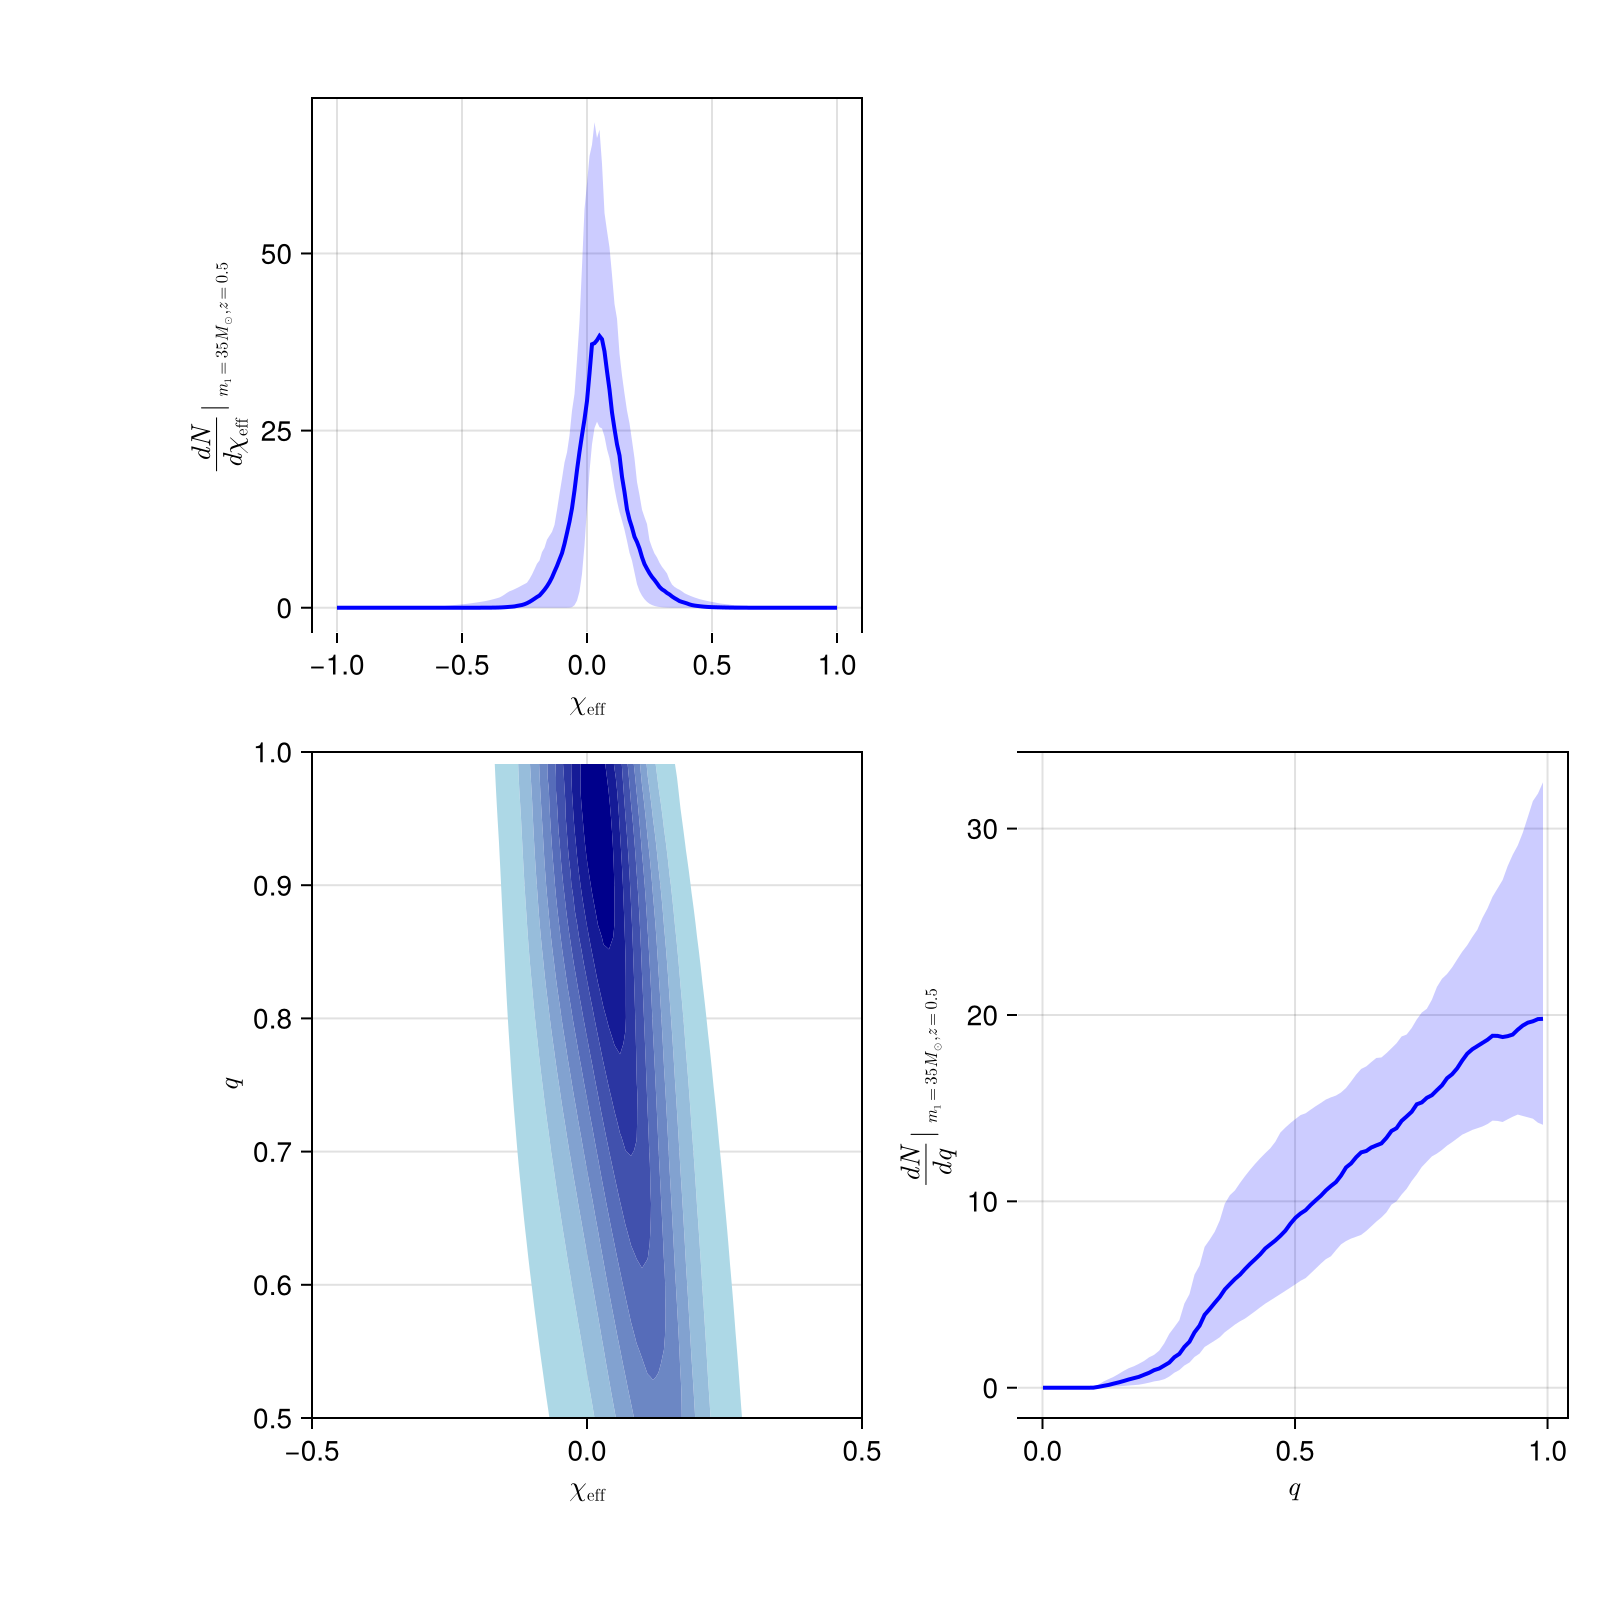

In [22]:
f = q_chieff_corner_plot(trace)
#save(joinpath(@__DIR__, "..", "figures", "q_chieff.pdf"), f)
f